# Figure 1 

Presented at the start of the results, this contains a comparison of different therapy methods, and exploration of the variation of the AT threshold

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import colormaps

sys.path.append("../utils")
from myUtils import convert_ode_parameters, calc_critical_treatment_threshold, calc_critical_treatment_interval, test_progression, TreatmentListToTS, ExtractTreatmentFromDf
from odeModels import LotkaVolterraModel
from plotUtils import PlotSimulation

In [8]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#0044AA' ,'Delta_T':'#66419e'}
linestyles=['-', (0, (10,10)), (0, (5,5))]

## Panel A - Treatment Comparison

In [9]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "Fig2")
runFromScratch = True

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)

In [73]:
# Compute performance under rule of thumb
at_model = LotkaVolterraModel(method='RK45')
at_model.SetParams(**odeParamDic)
at_model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=5000);
at_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at_model.Trim(dt=1)

# Compute performance under Better AT
at_plus_model = LotkaVolterraModel(method='RK45')
at_plus_model.SetParams(**odeParamDic)
at_plus_model.Simulate_AT(atThreshold=0.99, intervalLength=30, t_end=5000,
                          atMethod='Threshold')
at_plus_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at_plus_model.Trim(dt=1)
x_lim = max(at_plus_model.resultsDf['Time'])

# Compute performance under continuous therapy
ct_model = LotkaVolterraModel(method='RK45')
ct_model.SetParams(**odeParamDic)
ct_model.Simulate([[0, 2000, 1]])
ct_model.Trim(dt=1)
ct_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0']
ct_model.resultsDf = ct_model.resultsDf[ct_model.resultsDf['TumourSize'] < ct_model.resultsDf['TumourSize'][0] * 1.2]
ct_model.ttp = max(ct_model.resultsDf['Time'])

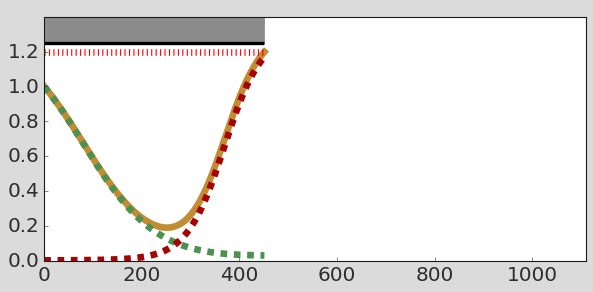

In [74]:
plt.rcParams['font.size'] = '18'
fix, ax = plt.subplots(1,1,figsize=(8,4))

palette = {'TumourSize': colors['CT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(ct_model.resultsDf, ax=ax, legend=False, colors = palette, linewidth=6)
# ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 6, color=colors["CT"], zorder=0)
ax.set_xlim(0, x_lim)

plt.savefig("../figures/fig1b_CT.pdf")

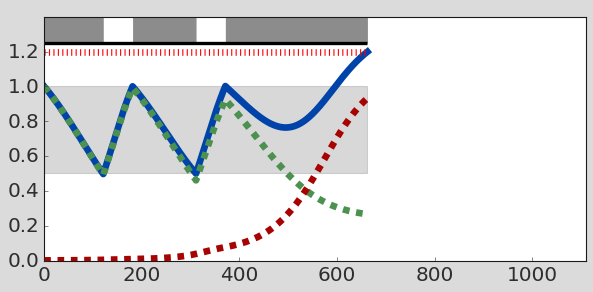

In [75]:
fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {'TumourSize': colors['AT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(at_model.resultsDf, ax=ax, legend=False, colors = palette, linewidth=6)
# ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth=6, color=colors["CT"], zorder=0)
# ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth=6, color=colors["AT"], zorder=0)

ax.fill_between([0, max(at_model.resultsDf.Time)], 0.5, 1, color='gray', alpha=0.3)
ax.set_xlim(0, x_lim)

ax.set_xlim(0, x_lim); ax.set_ylim(0, 1.4)
plt.savefig("../figures/fig1b_AT.pdf")

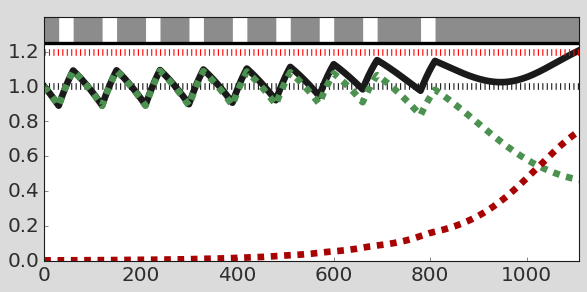

In [76]:
fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {'TumourSize': 'k', 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(at_plus_model.resultsDf, ax=ax, legend=False, colors = palette, linewidth=6)
# ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth=6, color=colors["CT"], zorder=0)
# ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth=6, color=colors["AT"], zorder=0)

ax.hlines(1, 0, max(at_plus_model.resultsDf.Time), linestyle=':', linewidth=6, color='k', zorder=0)
# ax.fill_between([0, max(at_plus_model.resultsDf.Time)], 0.8, 1, color='gray', alpha=0.3)


ax.set_xlim(0, x_lim); ax.set_ylim(0, 1.4)
plt.savefig("../figures/fig1b_AT_plus.pdf")

**Redo this to be based on a single threshold (with tau = 1) rather an ATX**

In [68]:
## Varying the adaptive threshold

def calc_ttp(params, threshold=0.5):
    model = LotkaVolterraModel()
    model.SetParams(**params)
    model.Simulate_AT(atThreshold=threshold, intervalLength=30, t_end=5000, 
                      atMethod='Threshold')
    return model.ttp

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
threshold_vals = np.linspace(0, 1.0, 11); #threshold_vals[-1] = 1.01
ttp_vals = [calc_ttp(odeParamDic, threshold=threshold) for threshold in threshold_vals]

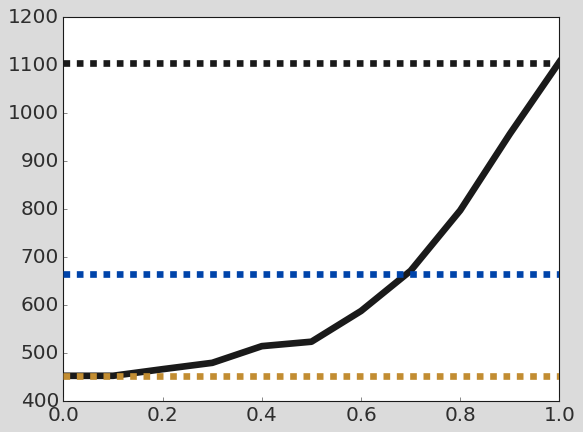

In [72]:
from matplotlib.ticker import FixedLocator, FixedFormatter

fix, ax = plt.subplots(1,1,figsize=(8,6))
plt.rcParams['font.size'] = '18'

ax.plot(threshold_vals, ttp_vals, linewidth=6, color='k')

ax.axhline(ct_model.ttp, 0, 1, linestyle='--', linewidth=6, color=colors["CT"], zorder=10)
ax.axhline(at_model.ttp, 0, 1, linestyle='--', linewidth=6, color=colors["AT"], zorder=10)
ax.axhline(at_plus_model.ttp, 0, 1, linestyle='--', linewidth=6, color='k', zorder=10)

plt.tick_params(right = False, top = False); #plt.xlim(0, 1); plt.ylim(400, 1100)

# x_labels = ['AT' + str(int(100 * x)) for x in ax.get_xticks()]
# x_labels[0] = 'CT'
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(x_labels)

# ax.set_xlabel("Adaptive threshold"); ax.set_ylabel("Time to progression")
plt.savefig("../figures/Fig1c_AT_thresholds.pdf")

_N.B Panels relating to the Bruchovsky data are given in the second notebook, `Fig2_Probing_Cycle.ipynb`._